In [1]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PrepareData import read_json, make_folder

In [3]:
repo_dir = sys.path[0].replace('notebooks', '')
eval_path=repo_dir+ 'eval/'

In [4]:
seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]

models = ['LR', 'TR']

datasets = ['meps16', 'lsac', 'ACSP', 'credit', 'ACSE', 'ACSH', 'ACSI']

In [5]:
eval_suffix = 'time'

eval_file = '{}_datasets{}_n{}.csv'.format(eval_suffix, len(datasets), len(seeds))
if os.path.exists(eval_path+eval_file):
    eval_df = pd.read_csv(eval_path+eval_file)
    print('Read results at {}'.format(eval_path+eval_file))
else:
    eval_df = pd.DataFrame()
    for data_name in datasets:
        cur_eval_df = pd.read_csv(eval_path+'{}-{}.csv'.format(eval_suffix, data_name))

        eval_df = pd.concat([eval_df, cur_eval_df])
    
    eval_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))

Read results at /Users/keyang/Projects/PubRepo/ConFair/eval/time_datasets7_n20.csv


In [6]:
eval_df = eval_df.dropna() # filter out the case that no model is returned
eval_df.head()

,data,model,seed,method,step,time
0,meps16,LR,1,MCC-ONE,prep,8.643763
1,meps16,LR,1,MCC-ONE,fairmodel,36.026663
2,meps16,LR,1,SCC-KAM,prep,8.643763
3,meps16,LR,1,SCC-KAM,fairmodel,32.005389
4,meps16,LR,1,OMN-ONE,prep,0.000000


In [7]:
def bar_plots_new(df, output_name, vis_datasets, vis_settings, step='total',
              legend_names=None, font_label=26, font_legend=18, color_map=None,
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670'], bg_color = '#f3f3f3', x_tick_offset=6.3,
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=5, save_to_disc=True):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    line_styles = []
    x_bars = []
    ind = 0
    bottom_bar_mean = []
    bottom_bar_std = []
    

    for off_i, name in enumerate(vis_datasets):
        vis_df = df[df['data']==name]
        for setting_i in vis_settings:
            
            set_df = vis_df[vis_df['method']==setting_i]
            
            
            bottom_df = set_df[set_df['step']=='prep']
            up_df = set_df[set_df['step']=='fairmodel']

            y_values = np.array(up_df['time'])
            
            cur_mean = np.mean(y_values)
            cur_std = np.std(y_values)

            bar_mean.append(cur_mean)
            bar_std.append(cur_std)
            
            bottom_y = np.array(bottom_df['time'])
            bottom_bar_mean.append(np.mean(bottom_y))
            bottom_bar_std.append(np.std(bottom_y))
                
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
            
    total_mean = [x+y for x, y in zip(bottom_bar_mean, bar_mean)]
    y_max = max(total_mean)
    
    if step == 'total':
        total_std = [x+y for x, y in zip(bottom_bar_std, bar_std)]
        bplot = ax.bar(x_bars, total_mean, yerr=total_std)
        
        
    elif step == 'prep':
        bplot = ax.bar(x_bars, bottom_bar_mean, yerr=bottom_bar_std)
        
       
    elif step == 'fairmodel':
        
        bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)
    else:
        raise ValueError('Not valid step specified!')
    
    
    n_bars = len(vis_settings)

    for idx, patch in enumerate(bplot):
        cur_setting = vis_settings[idx % n_bars]
        face_c = color_map[cur_setting]['face']
        fill_c = color_map[cur_setting]['filling']
        patch.set_facecolor(face_c)
        
        patch.set_edgecolor("black")
        
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_map[setting_i]['face'], label=legend_i)

    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    plt.xlim([-1, max(x_bars)+1])
    
    
    plt.xticks([(x-1)*x_tick_offset+0.8 for x in range(1, len(vis_datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)
    
    plt.yscale('log')
    
    
    if save_to_disc:
        plt.savefig(output_name, bbox_inches="tight")
        print('Bar plot is saved at ', output_name)
        plt.close()

In [8]:
plot_path = repo_dir+ 'intermediate/plots/time/'
make_folder(plot_path)

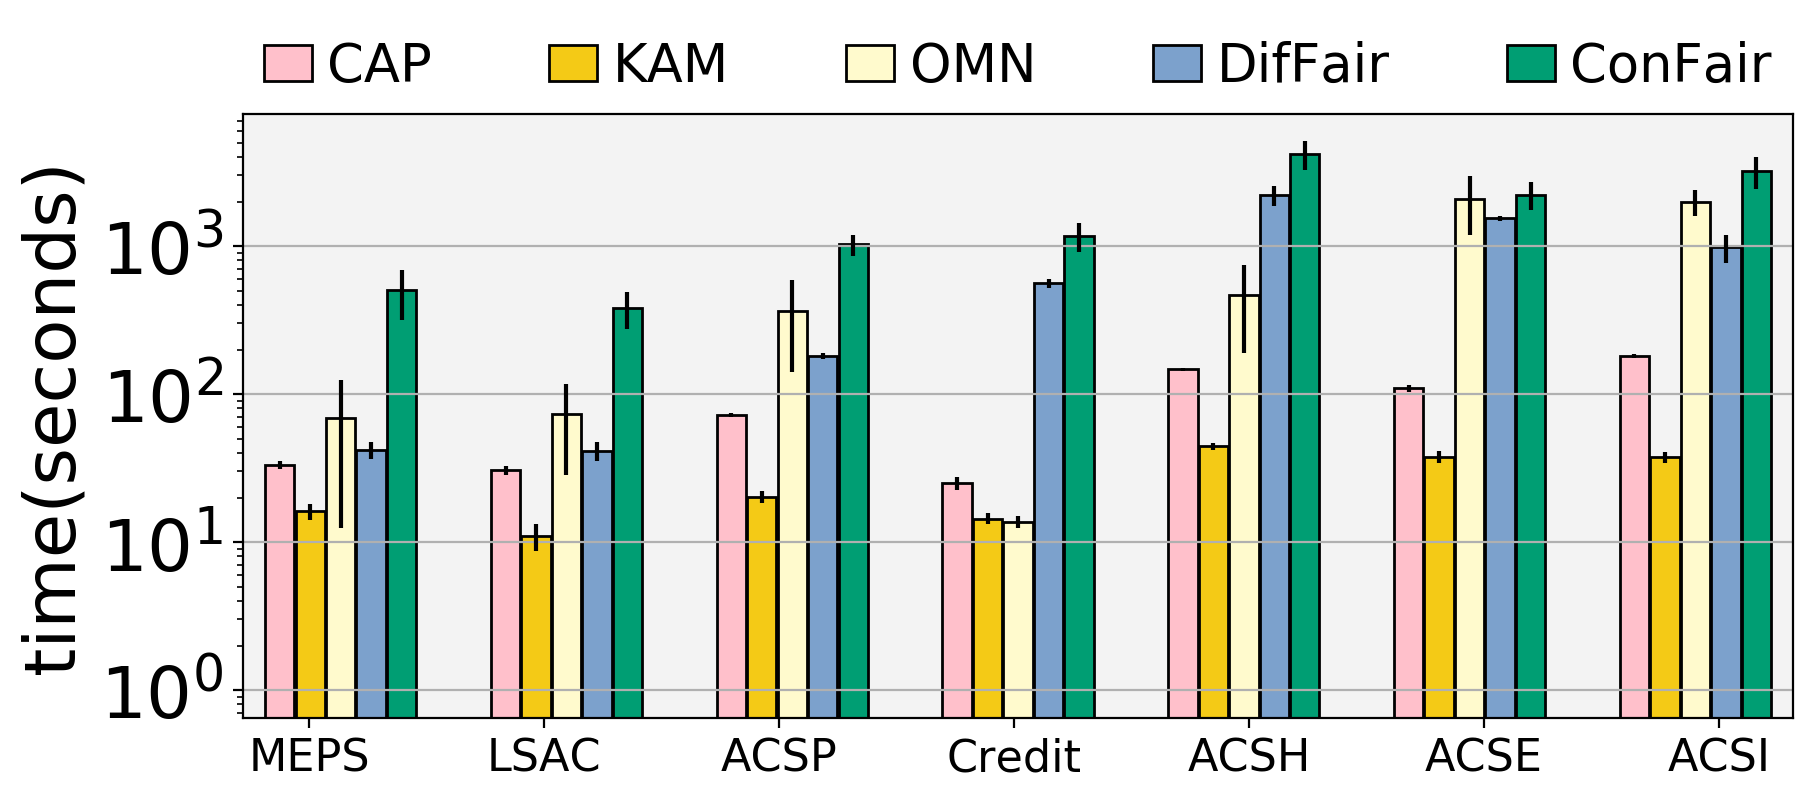

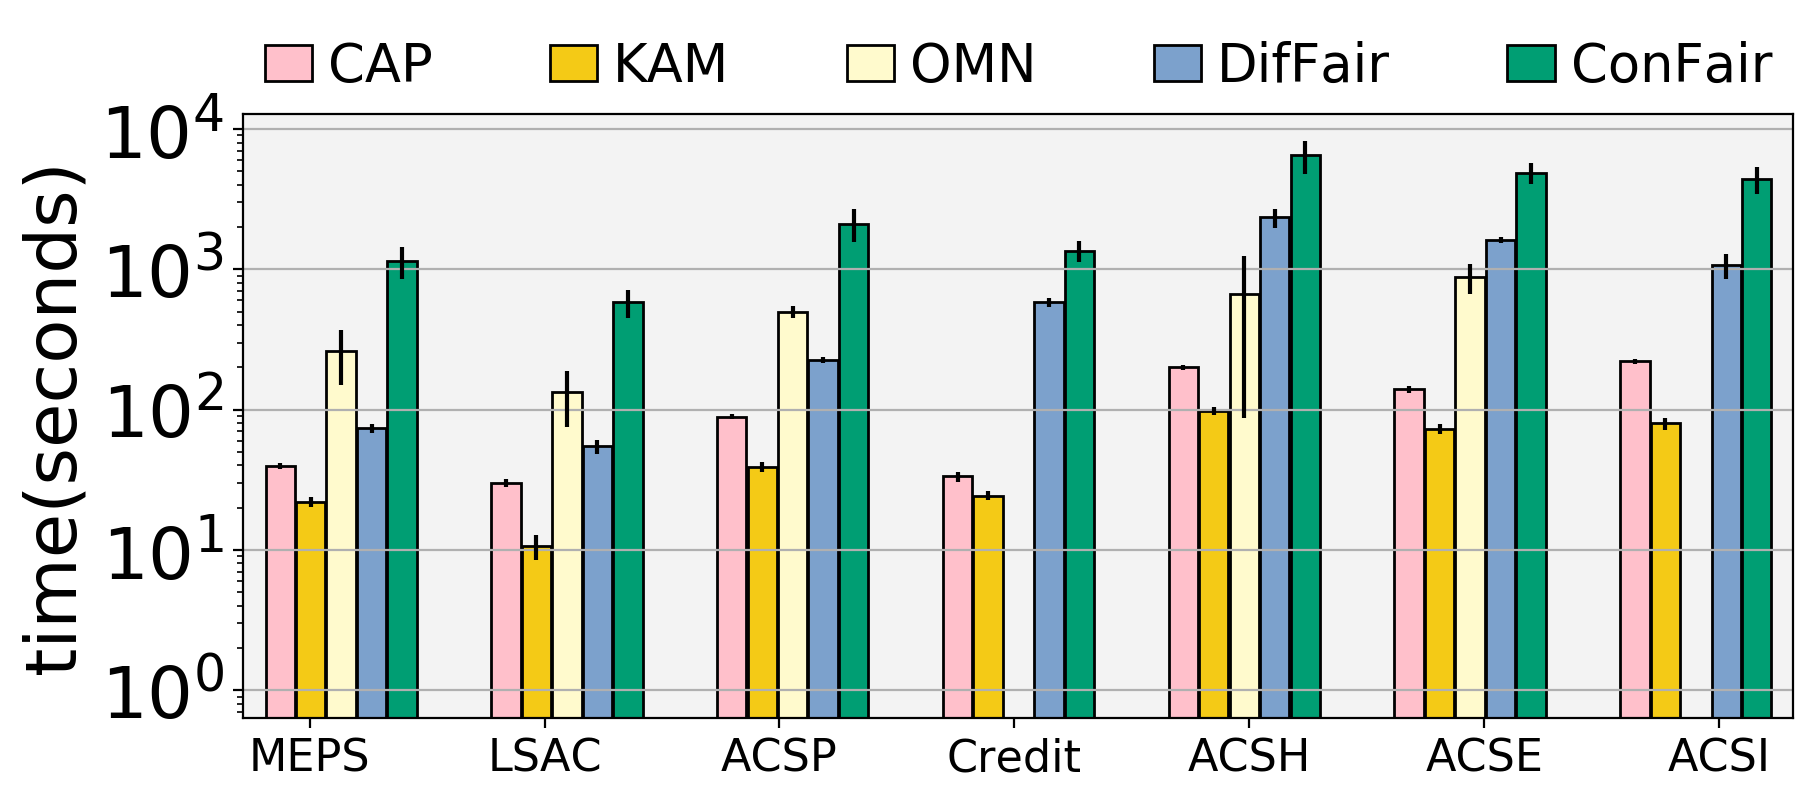

In [9]:
# new order of datasets
exp_datasets = ['meps16', 'lsac', 'ACSP', 'credit', 'ACSH', 'ACSE', 'ACSI']
exp_ticks = ['MEPS', 'LSAC', 'ACSP', 'Credit', 'ACSH', 'ACSE', 'ACSI']


scc_settings = ['CAP-ONE', 'KAM-ONE', 'OMN-ONE', 'MCC-ONE', 'SCC-KAM']
scc_legends = ['CAP', 'KAM', 'OMN', 'DifFair', 'ConFair']

color_map = {'ORIG': {'face':'#ffffff', 'filling':'black'},
             'MCC-MIN-NOOPT': {'face':'#2b4a96', 'filling':'white'},
             'MCC-MIN': {'face':'#7ca1cc', 'filling':'black'},
             'SCC-KAM-NOOPT': {'face':'#004d38', 'filling':'white'},
             'SCC-KAM': {'face':'#009e73', 'filling':'black'},
             'SEP': {'face':'#fffacd', 'filling':'black'},
             'MCC-W2': {'face':'#7ca1cc', 'filling':'black'},
             'KAM-ONE': {'face':'#f4ca16', 'filling':'black'},
             'OMN-ONE': {'face':'#fffacd', 'filling':'black'},
             'CAP-ONE': {'face':'#ffc0cb', 'filling':'black'},
             'MCC-ONE': {'face':'#7ca1cc', 'filling':'black'}
            }

x_tick_set = 6.4     

step = 'total'
# step = 'prep'
# step = 'fairmodel'

for idx, model_name in enumerate(['LR', 'TR']):
    if idx > 0:
        y_label = 'time(seconds)'
    else:
        y_label = 'time(seconds)'
    output_name = '{}{}-{}.png'.format(plot_path, model_name, step)
    model_df = eval_df[eval_df['model']==model_name]
    bar_plots_new(model_df, output_name, exp_datasets, scc_settings, step=step, 
                  x_ticks=exp_ticks, color_map=color_map, 
              legend_names=scc_legends, x_tick_offset=x_tick_set, y_label=y_label,
              legend_col=len(scc_settings),
              save_to_disc=False)